<a href="https://colab.research.google.com/github/IggyZhao/Google-Stock-Project-Iggy-/blob/master/Time_series_Google_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [20,8]

# Prepare the data

In [ ]:
# Load the data
from google.colab import files
uploaded = files.upload()

Saving Google_Stock_Price_Train.csv to Google_Stock_Price_Train.csv


In [ ]:
train =pd.read_table('Google_Stock_Price_Train.csv',header=0,sep=',',lineterminator='\n')
print(train.head())

        Date    Open    High     Low   Close   Volume
0  26-Sep-17  936.69  944.08  935.12  937.43  1672749
1  25-Sep-17  939.45  939.75  924.51  934.28  1873375
2  22-Sep-17  942.77  950.00  940.84  943.26  1074806
3  21-Sep-17  948.13  952.80  939.38  947.55  1370685
4  20-Sep-17  937.73  950.00  937.50  947.54  2004018


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [ ]:
train['date'] = train['Date'].astype('datetime64[ns]')
train.set_index('date', inplace=True)

/usr/local/lib/python2.7/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


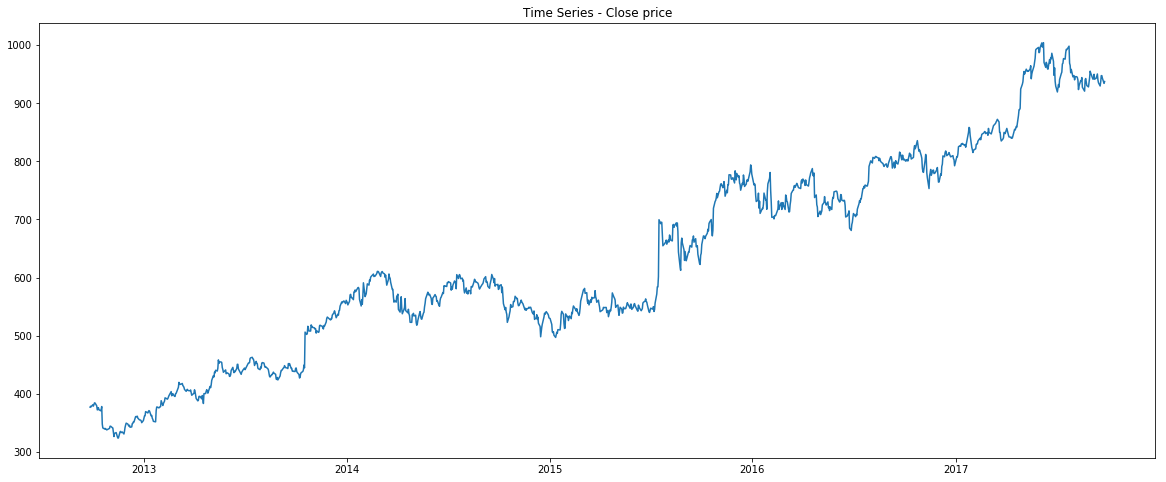

In [ ]:
mean_group = train.Close
plt.plot(mean_group)
plt.title('Time Series - Close price')
plt.show()

# Check the stationarity

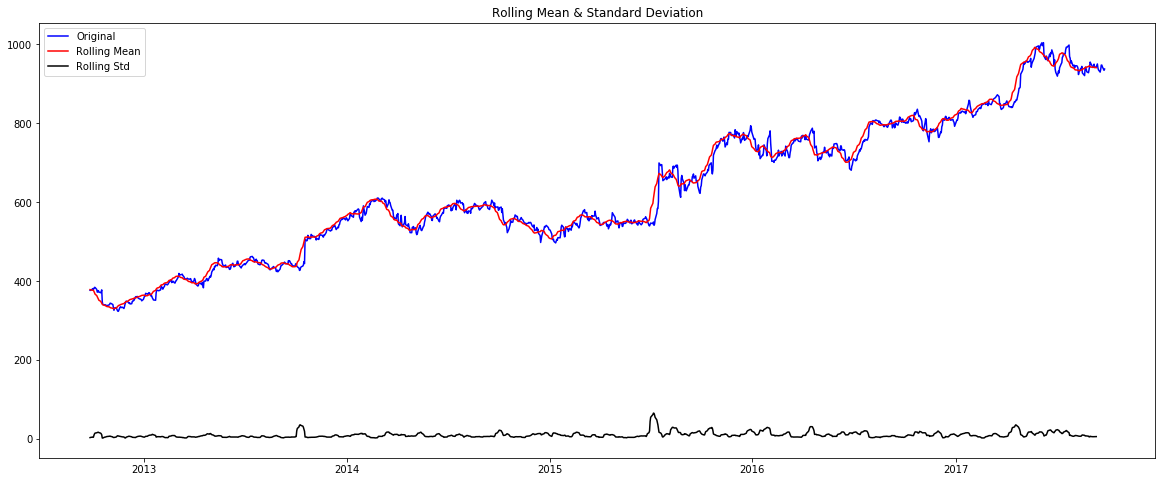

Results of Dickey-Fuller Test:
Test Statistic                   -1.167719
p-value                           0.687326
#Lags Used                        0.000000
Number of Observations Used    1257.000000
Critical Value (5%)              -2.863842
Critical Value (1%)              -3.435563
Critical Value (10%)             -2.567996
dtype: float64


In [ ]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    rolmean = timeseries.rolling(12).mean() 
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test: 
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

test_stationarity(mean_group)

Result: Failed to reject the the null hypothesis that the process is non-stationary

# How to transform to a stationary process

## Moving average

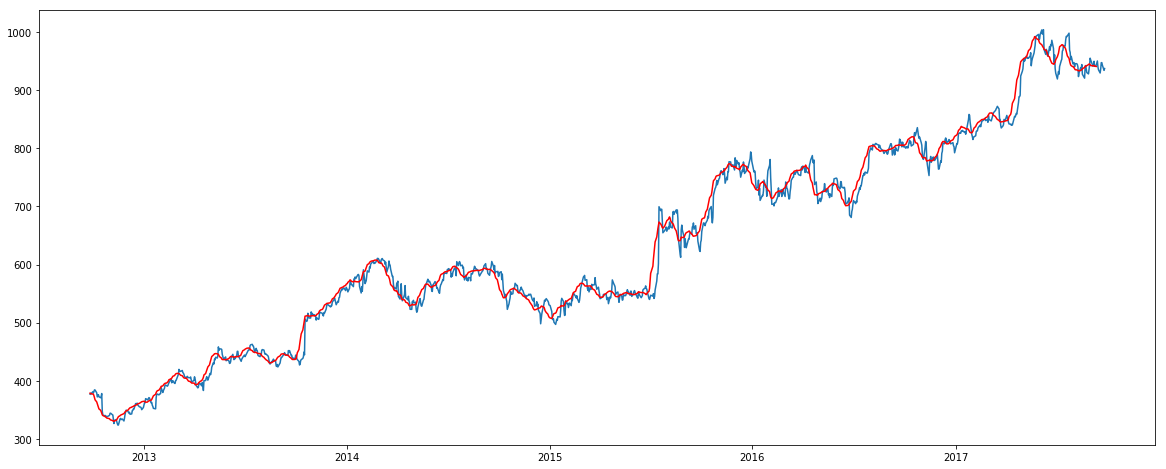

In [ ]:
moving_avg = mean_group.rolling(12).mean()
plt.plot(mean_group)
plt.plot(moving_avg, color='red')

In [ ]:
moving_avg_diff = mean_group - moving_avg
moving_avg_diff.head(12)

date
2017-09-26         NaN
2017-09-25         NaN
2017-09-22         NaN
2017-09-21         NaN
2017-09-20         NaN
2017-09-19         NaN
2017-09-18         NaN
2017-09-15         NaN
2017-09-14         NaN
2017-09-13         NaN
2017-09-12         NaN
2017-09-11    2.250833
Name: Close, dtype: float64

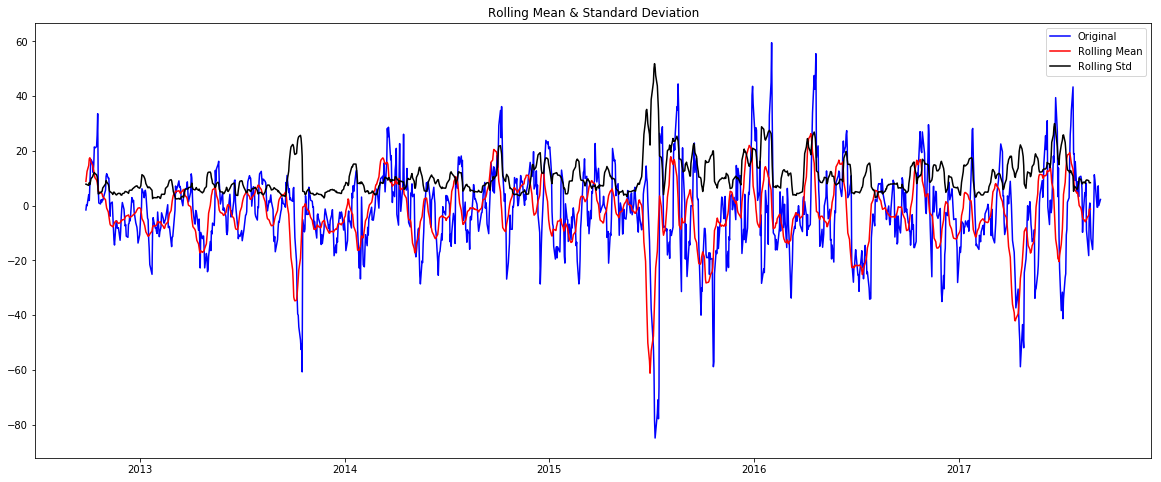

Results of Dickey-Fuller Test:
Test Statistic                -8.057386e+00
p-value                        1.678269e-12
#Lags Used                     1.100000e+01
Number of Observations Used    1.235000e+03
Critical Value (5%)           -2.863883e+00
Critical Value (1%)           -3.435656e+00
Critical Value (10%)          -2.568018e+00
dtype: float64


In [ ]:
moving_avg_diff.dropna(inplace=True)
test_stationarity(moving_avg_diff)

P value is much smaller, reject the null hypotheses in terms of the alternetive: The process is stationary.

## Exponential weighted moving average

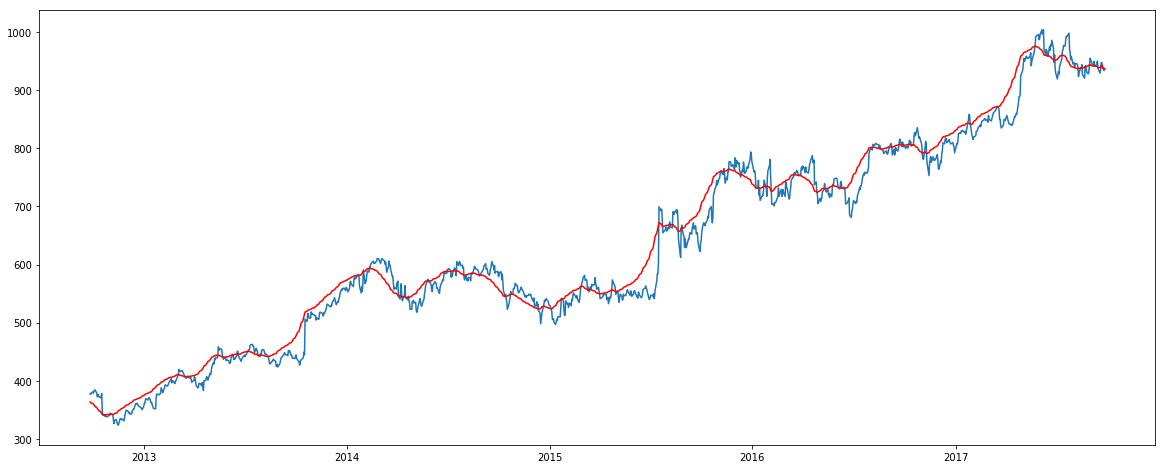

In [ ]:
expwighted_avg = mean_group.ewm(halflife=12).mean()
plt.plot(mean_group)
plt.plot(expwighted_avg, color='red')

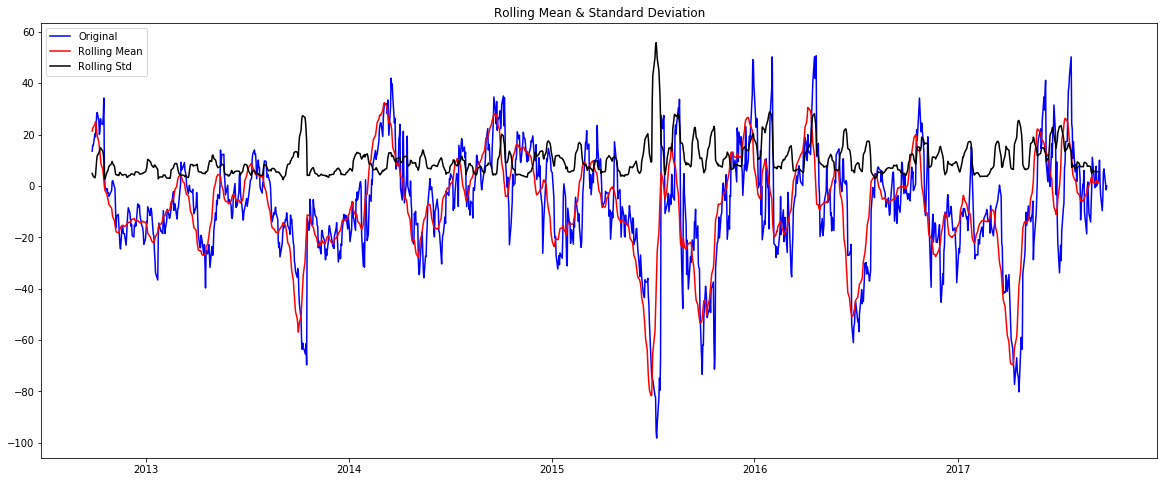

Results of Dickey-Fuller Test:
Test Statistic                -7.113198e+00
p-value                        3.890755e-10
#Lags Used                     1.000000e+00
Number of Observations Used    1.256000e+03
Critical Value (5%)           -2.863844e+00
Critical Value (1%)           -3.435567e+00
Critical Value (10%)          -2.567997e+00
dtype: float64


In [ ]:
ewma_diff = mean_group - expwighted_avg
test_stationarity(ewma_diff)

Stationary

## Differencing

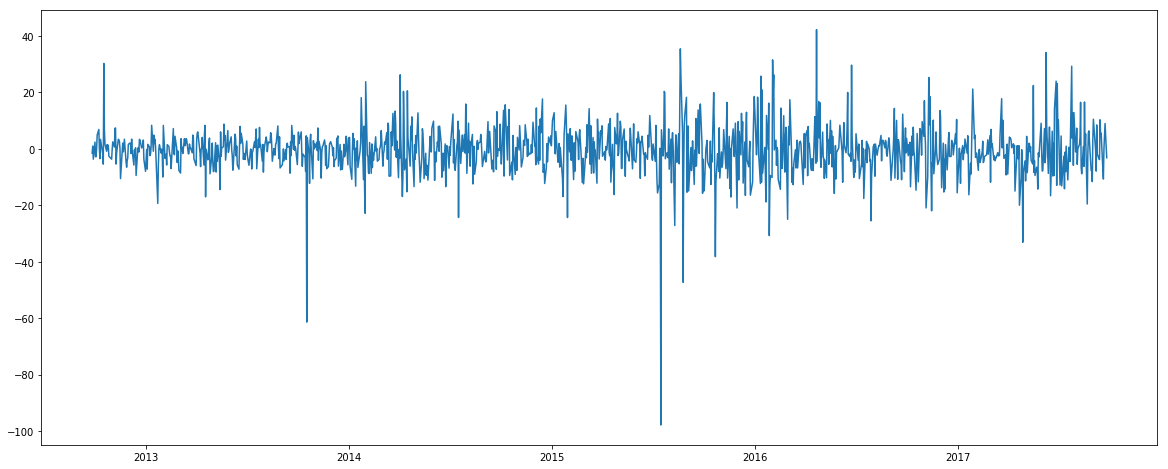

In [ ]:
mean_group_diff = mean_group - mean_group.shift()
plt.plot(mean_group_diff)

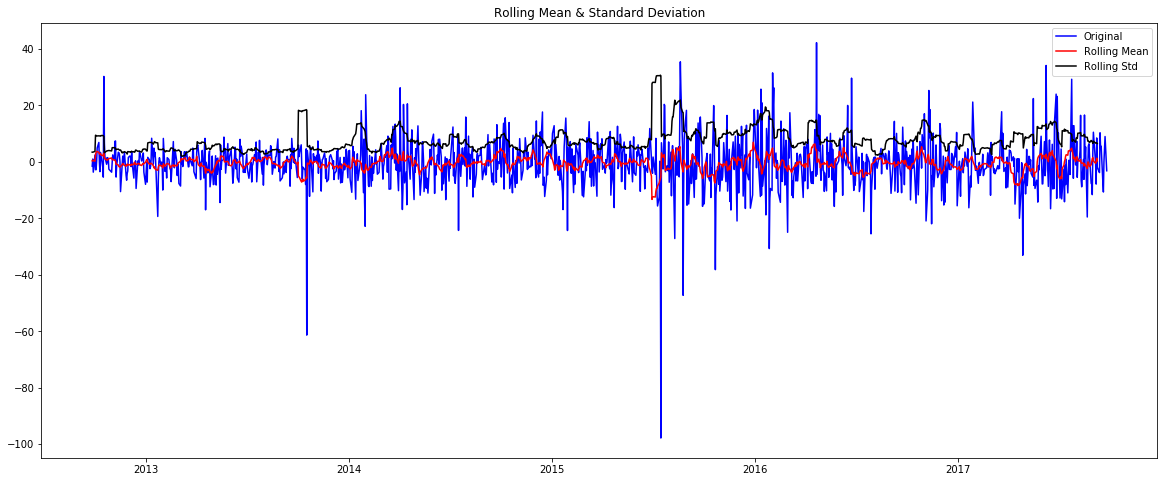

Results of Dickey-Fuller Test:
Test Statistic                  -34.011932
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1256.000000
Critical Value (5%)              -2.863844
Critical Value (1%)              -3.435567
Critical Value (10%)             -2.567997
dtype: float64


In [ ]:
mean_group_diff.dropna(inplace=True)
test_stationarity(mean_group_diff)

## Decomposing

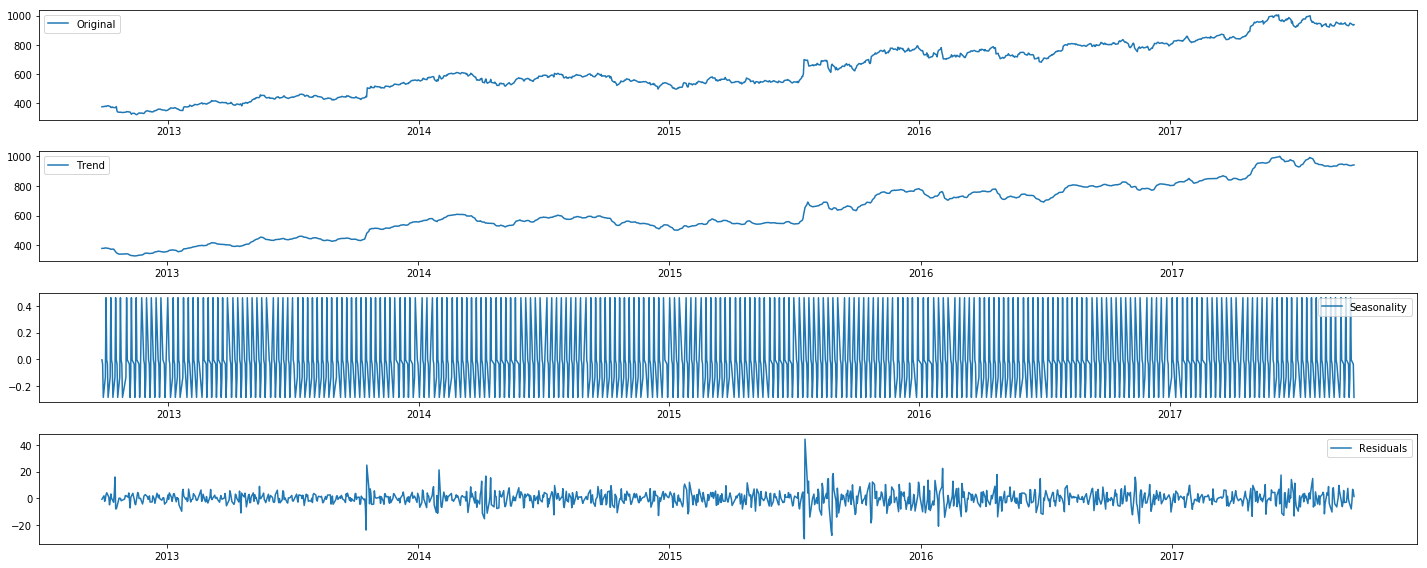

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(mean_group, freq = 5)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(mean_group, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

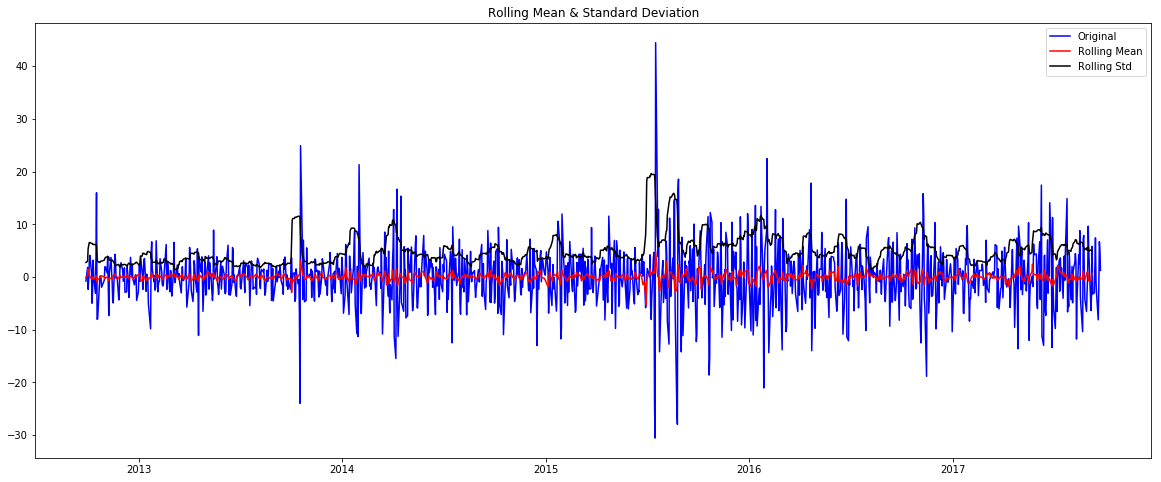

Results of Dickey-Fuller Test:
Test Statistic                -1.549098e+01
p-value                        2.485113e-28
#Lags Used                     1.800000e+01
Number of Observations Used    1.235000e+03
Critical Value (5%)           -2.863883e+00
Critical Value (1%)           -3.435656e+00
Critical Value (10%)          -2.568018e+00
dtype: float64


In [ ]:
mean_group_decompose = residual
mean_group_decompose.dropna(inplace=True)
test_stationarity(mean_group_decompose)

# Forecasting

## ACF and PACF

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(residual, nlags=20)
lag_pacf = pacf(residual, nlags=20, method='ols')

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


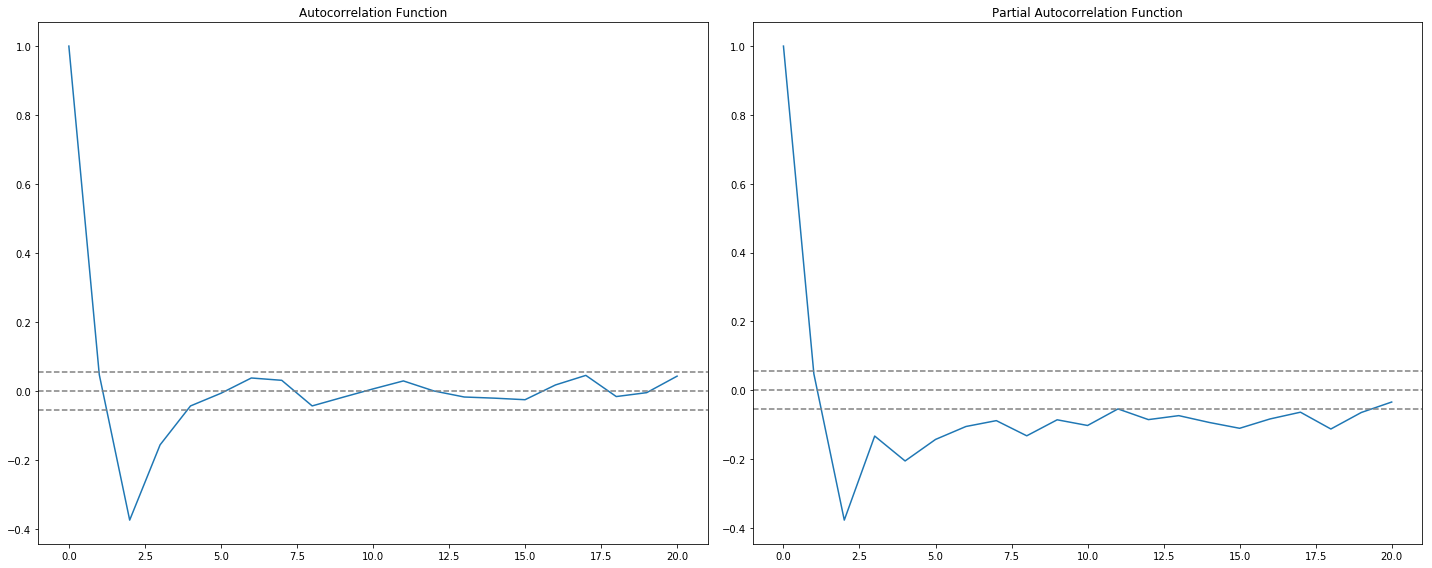

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mean_group_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## AR model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import aicc

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 37472.7383')

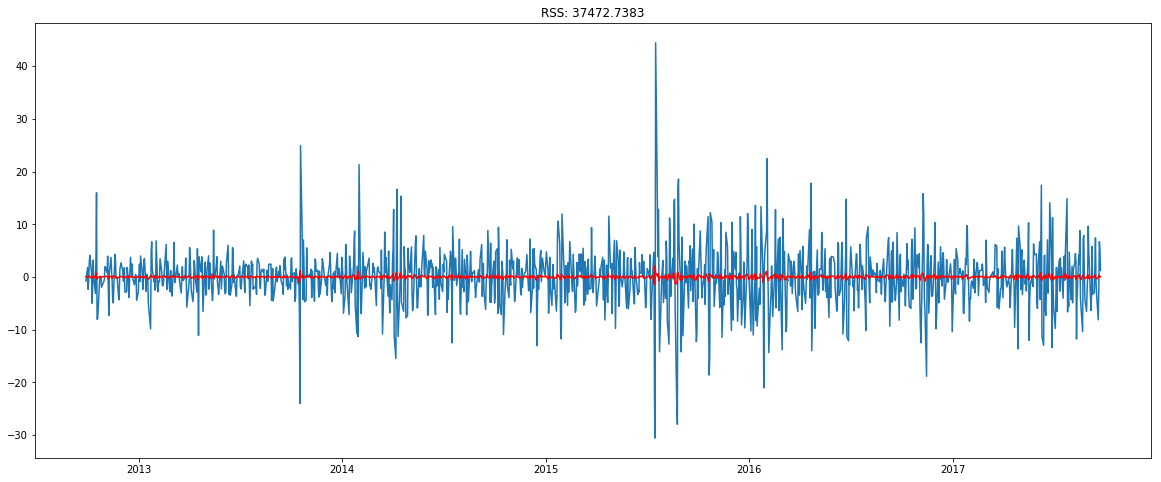

In [ ]:
model = ARIMA(residual, order=(1, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-residual)**2))

## MA

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 37266.0572')

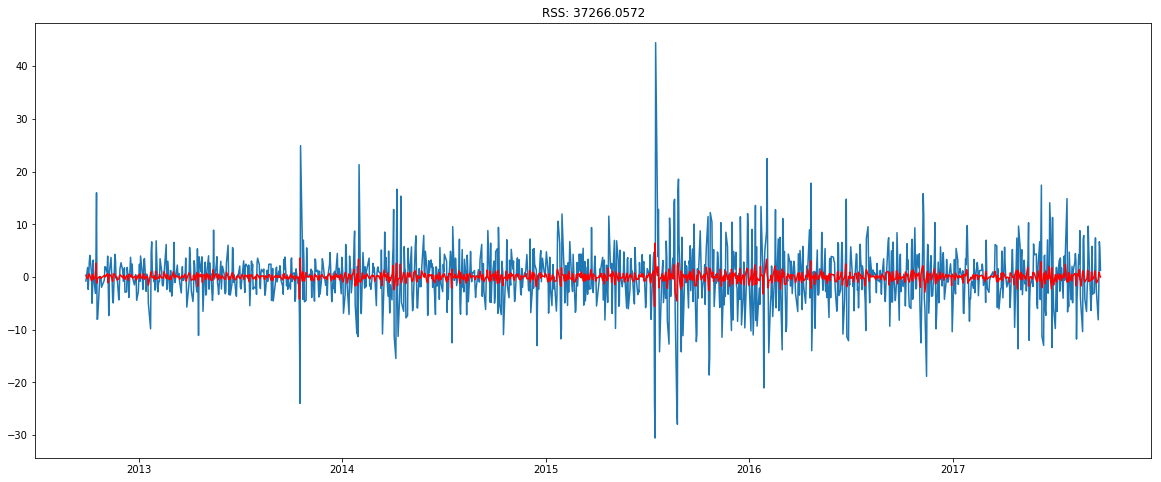

In [ ]:
model = ARIMA(residual, order=(0, 0, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-residual)**2))

## ARMA

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 29562.7636')

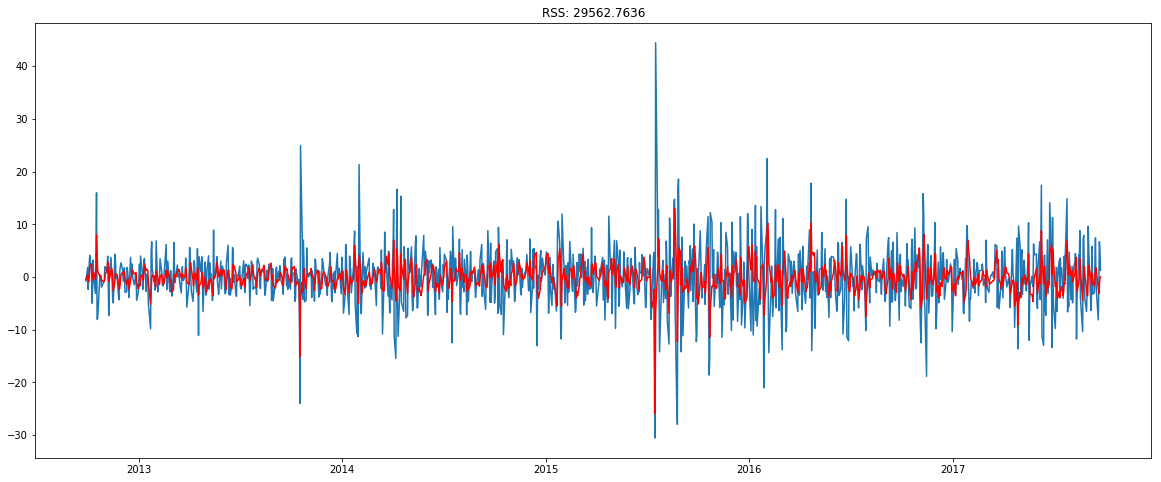

In [ ]:
model = ARIMA(residual, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual)**2))

## Grid search for p, q

In [ ]:
mat_aic = np.zeros((5,5))
for p in range(1, 6):
  for q in range(1, 6):
    try:
      model = ARIMA(residual, order=(p, 0, q))  
      results_ARIMA = model.fit(disp=-1)  
      mat_aic[p-1][q-1] = results_ARIMA.aic
    except:
      print "not invertible"
    

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


not invertible
not invertible


/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


not invertible
not invertible


/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

In [ ]:
mat_aic

array([[7529.31742294,    0.        ,    0.        ,    0.        ,
           0.        ],
       [7380.12126432, 7361.31775107, 7360.83312965, 7362.28958009,
        7364.09494074],
       [7368.12445524, 7362.30753423, 7363.96064794, 7362.33529992,
        7360.97044366],
       [7362.12662422, 7363.50507516, 7364.24343307, 7362.5948717 ,
        7362.84528788],
       [7363.54156289, 7363.50802343, 7366.12728939, 7367.19470874,
        7364.14993692]])

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7361.31775107


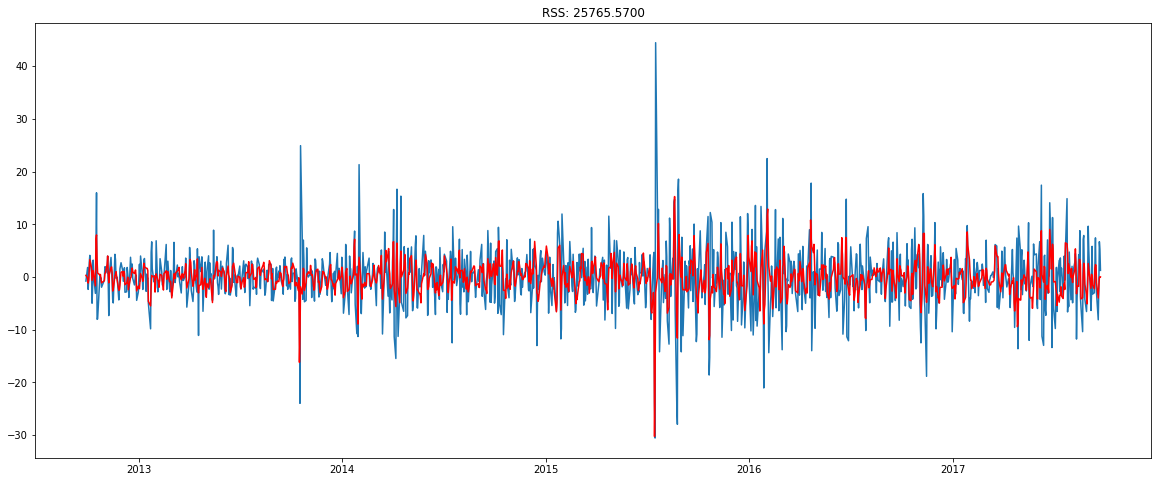

In [ ]:
model = ARIMA(residual, order=(2, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual)**2))
print results_ARIMA.aic

## Take it back to original scale

In [ ]:
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA.head()

date
2017-09-22   -0.000192
2017-09-21    0.055022
2017-09-20   -0.172496
2017-09-19   -2.150310
2017-09-18   -3.990474
dtype: float64


In [ ]:
predictions_all = pd.Series(0, index=mean_group.index)
predictions_all = predictions_all.add(trend).add(seasonal).add(predictions_ARIMA)
print predictions_all.head()

date
2012-09-26           NaN
2012-09-27           NaN
2012-09-28    378.722077
2012-10-01    379.238462
2012-10-02    380.064333
dtype: float64


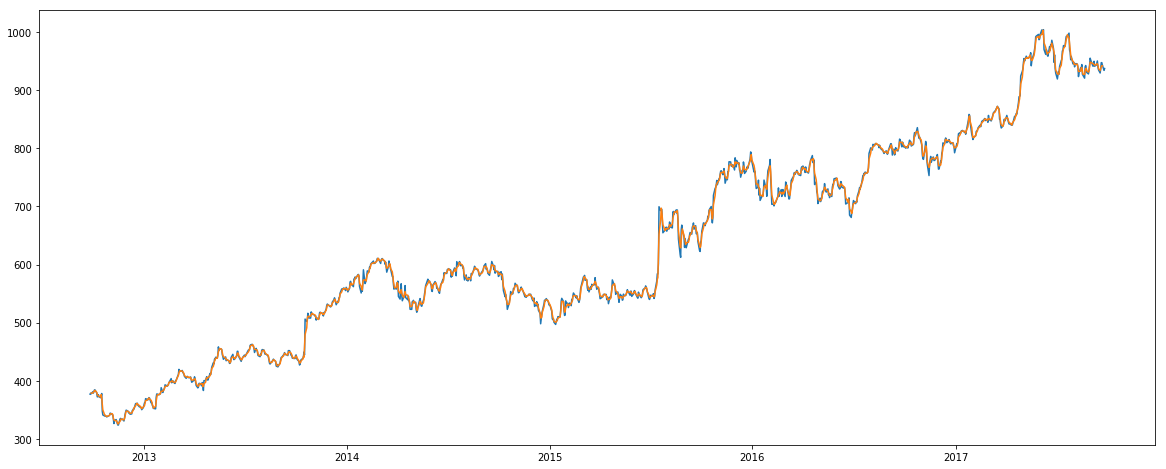

In [ ]:
plt.plot(mean_group)
plt.plot(predictions_all)